In [10]:
import pandas as pd
import pickle
import os
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
path_to_processed_dataset_folder = '/home/shoaib/gnn/gcn/datasets'

In [12]:
if os.path.exists(path_to_processed_dataset_folder):
  print("Directory exists")
else:
  print("Directory not exists")

Directory exists


In [13]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils import add_self_loops, coalesce
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.utils import index_to_mask
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [14]:
torch.manual_seed(0)
np.random.seed(0)

In [15]:
# Load node attributes, adjacency matrix, and labels from .npy files
node_attributes = np.load(f'{path_to_processed_dataset_folder}/node_attributes.npy', allow_pickle = True)
adj = np.load(f'{path_to_processed_dataset_folder}/adjacency_matrix.npy', allow_pickle = True)
y = np.load(f'{path_to_processed_dataset_folder}/labels_v2.npy', allow_pickle = True)

In [16]:
node_attributes

array([[1.27, 11122.0, 11272.0, ..., 0.0, 0.0, 0.0],
       [1.06, 267.0, 1359.0, ..., 0.0, 0.0, 0.0],
       [1.33, 537.0, 409.0, ..., 0.0, 0.0, 0.0],
       ...,
       [14.511231890100216, 47.83230057107836, 14.0091382248733, ...,
        1.42, 0.94, 0.24],
       [13.5591, 45.29501831501835, 14.264175824175828, ..., 0.0, 0.0,
        1.01],
       [12.254254345995212, 61.67082158675014, 10.53875914973744, ...,
        1.4, 0.06, 2.02]], dtype=object)

In [17]:
# Convert adjacency matrix to edge index
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)

# Convert node attributes to tensor
node_attributes = node_attributes.astype(np.float32)
x = torch.from_numpy(node_attributes).to(torch.float)

# Add self loops to the edge index
edge_index, _ = add_self_loops(edge_index, None)

# Coalesce the edge index
num_nodes = x.size(0)
edge_index, _ = coalesce(edge_index, None, num_nodes, num_nodes)

# Convert labels to tensor and pad with zeros
y = torch.from_numpy(y.squeeze()).to(torch.long)
#y = torch.cat((y, torch.zeros(num_nodes - y.size()[0], dtype=torch.long)))

# Create Data object
data = Data(x=x, edge_index=edge_index, y=y)

In [18]:
print(edge_index)
print(len(edge_index))
print(edge_index.shape[1])

tensor([[    0,     0,     1,  ..., 13337, 13338, 13339],
        [    0, 13202,     1,  ..., 13337, 13338, 13339]])
2
26494


In [19]:
train_per = 0.8  # Adjust as needed

y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(range(y.size), y.squeeze(),
                                                    test_size=1 - train_per - 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=train_per / (train_per + 0.1), random_state=42)

train_index = torch.tensor(X_train, dtype=torch.long)
val_index = torch.tensor(X_val, dtype=torch.long)
test_index = torch.tensor(X_test, dtype=torch.long)

train_mask = index_to_mask(train_index, size=num_nodes)
val_mask = index_to_mask(val_index, size=num_nodes)
test_mask = index_to_mask(test_index, size=num_nodes)

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [20]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=-1)

In [21]:
num_classes = len(np.unique(y))  # Adjust as needed
num_classes

3

In [22]:

model = GCN(num_features=x.size(1), num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
path_to_saved_model_folder = '/home/shoaib/gnn/gcn/saved-models'
model_name = 'gcn_model_128'
path = f'{path_to_saved_model_folder}/{model_name}.pth'


In [30]:
# loss function optimization considering the only two classes 

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    
    # Create a mask for the fake and real news
    news_mask = (data.y[data.train_mask] == 0) | (data.y[data.train_mask] == 1)
    
    # Apply the mask to the output and labels
    out_news = out[data.train_mask][news_mask]
    labels_news = data.y[data.train_mask][news_mask]
    
    # Compute the loss only for the fake and real news
    loss = F.nll_loss(out_news, labels_news)
    
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]
        
        # Create a mask for the fake and real news
        news_mask = (data.y[mask] == 0) | (data.y[mask] == 1)
        
        # Apply the mask to the predictions and labels
        preds_news = preds[mask][news_mask]
        labels_news = data.y[mask][news_mask]
        
        correct = preds_news.eq(labels_news).sum().item()
        acc = correct / news_mask.sum().item()
        return acc, preds_news, labels_news


In [31]:
# Best accuracy from epochs

best_acc = 0.0
best_epoch = 0
best_state_dict = None
patience = 100  # Number of epochs to wait for improvement before stopping
wait = 0

for epoch in range(1, 500):
    loss = train()
    train_acc, _, _ = test(data.train_mask)
    val_acc, _, _ = test(data.val_mask)
    test_acc, preds, labels = test(data.test_mask)
    
    # Save the model parameters if this epoch has the best accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        best_state_dict = model.state_dict()
        wait = 0  # Reset the counter
    else:
        wait += 1  # Increment the counter if no improvement
    
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Stop training if no improvement for 'patience' epochs
    if wait >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

print(f'Best Val Acc: {best_acc} at Epoch: {best_epoch}')

Epoch: 1, Loss: 1858.1809, Train Acc: 0.4865, Val Acc: 0.4558, Test Acc: 0.4737
Epoch: 2, Loss: 990.3026, Train Acc: 0.5270, Val Acc: 0.5510, Test Acc: 0.5263
Epoch: 3, Loss: 4029.2957, Train Acc: 0.5878, Val Acc: 0.5986, Test Acc: 0.5789
Epoch: 4, Loss: 1761.4810, Train Acc: 0.6419, Val Acc: 0.6054, Test Acc: 0.5789
Epoch: 5, Loss: 553.5255, Train Acc: 0.5135, Val Acc: 0.4762, Test Acc: 0.4737
Epoch: 6, Loss: 1163.5897, Train Acc: 0.8108, Val Acc: 0.7823, Test Acc: 0.7632
Epoch: 7, Loss: 716.9342, Train Acc: 0.7770, Val Acc: 0.7551, Test Acc: 0.7368
Epoch: 8, Loss: 1169.8228, Train Acc: 0.7770, Val Acc: 0.7551, Test Acc: 0.7368
Epoch: 9, Loss: 1356.3105, Train Acc: 0.7770, Val Acc: 0.7483, Test Acc: 0.6842
Epoch: 10, Loss: 1256.5653, Train Acc: 0.8108, Val Acc: 0.7959, Test Acc: 0.8158
Epoch: 11, Loss: 1097.6278, Train Acc: 0.8243, Val Acc: 0.8299, Test Acc: 0.8158
Epoch: 12, Loss: 1176.1716, Train Acc: 0.8176, Val Acc: 0.8095, Test Acc: 0.7632
Epoch: 13, Loss: 1340.4785, Train Acc: 0

In [32]:
path_to_saved_model_folder = '/home/shoaib/gnn/gcn/saved-models'
model_name = 'gcn_model_128'
path = f'{path_to_saved_model_folder}/{model_name}.pth'

torch.save(best_state_dict, path)

Fold 1 Test Accuracy: 0.918918918918919
Fold 1 Test F1 Score: 0.918918918918919
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.89      0.94      0.92        18

    accuracy                           0.92        37
   macro avg       0.92      0.92      0.92        37
weighted avg       0.92      0.92      0.92        37



/tmp/ipykernel_122407/2467983976.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


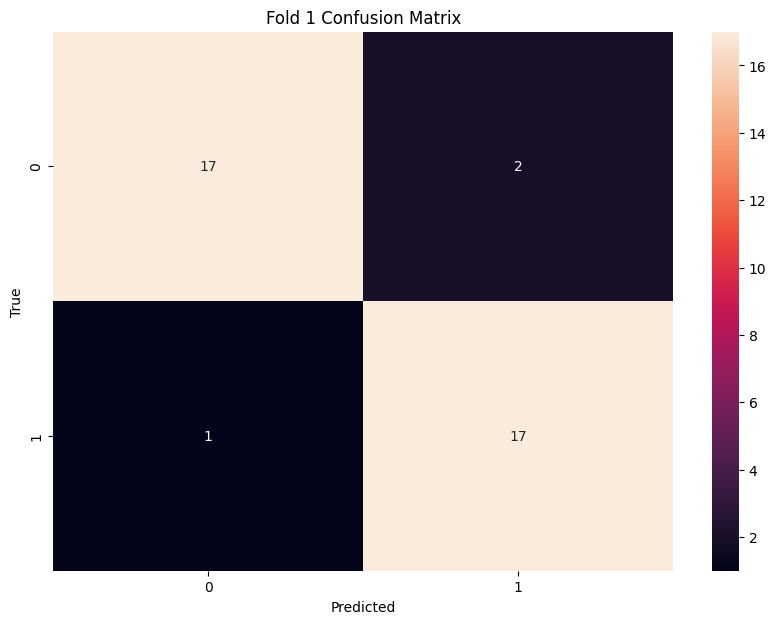

/tmp/ipykernel_122407/2467983976.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Fold 2 Test Accuracy: 0.7837837837837838
Fold 2 Test F1 Score: 0.7834676782045203
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        19
           1       0.75      0.83      0.79        18

    accuracy                           0.78        37
   macro avg       0.79      0.79      0.78        37
weighted avg       0.79      0.78      0.78        37



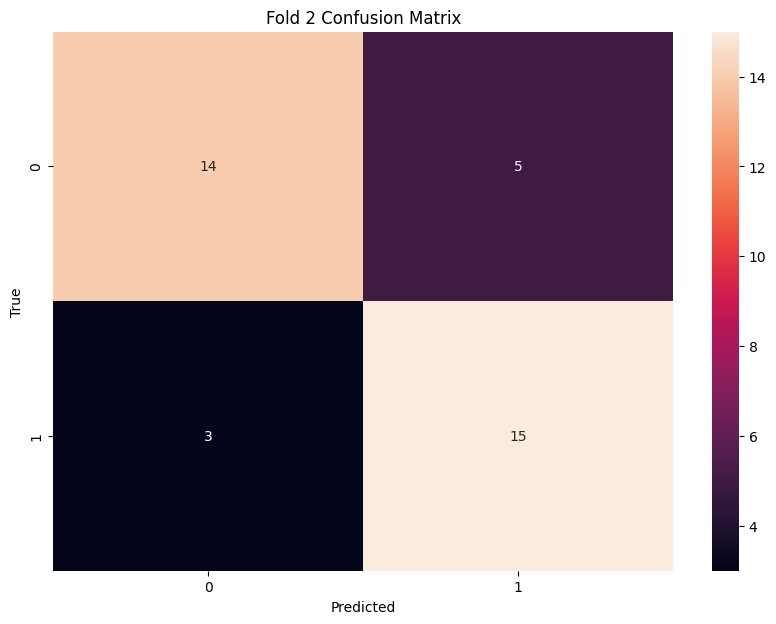

Fold 3 Test Accuracy: 0.8108108108108109
Fold 3 Test F1 Score: 0.8048498611139271
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.63      0.77        19
           1       0.72      1.00      0.84        18

    accuracy                           0.81        37
   macro avg       0.86      0.82      0.81        37
weighted avg       0.86      0.81      0.80        37



/tmp/ipykernel_122407/2467983976.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


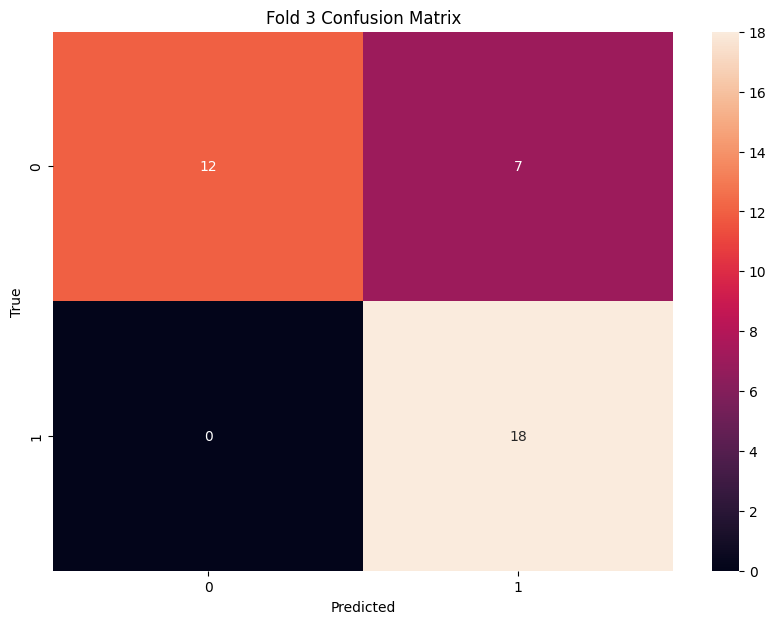

/tmp/ipykernel_122407/2467983976.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Fold 4 Test Accuracy: 0.972972972972973
Fold 4 Test F1 Score: 0.9730125730125728
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.94      1.00      0.97        17

    accuracy                           0.97        37
   macro avg       0.97      0.97      0.97        37
weighted avg       0.97      0.97      0.97        37



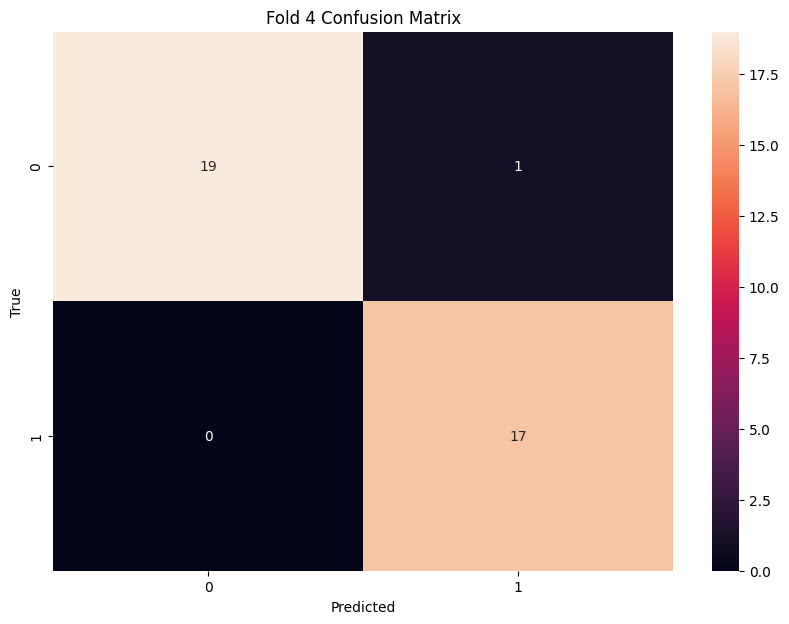

/tmp/ipykernel_122407/2467983976.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Fold 5 Test Accuracy: 0.7631578947368421
Fold 5 Test F1 Score: 0.7633220264799212
Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        20
           1       0.74      0.78      0.76        18

    accuracy                           0.76        38
   macro avg       0.76      0.76      0.76        38
weighted avg       0.76      0.76      0.76        38



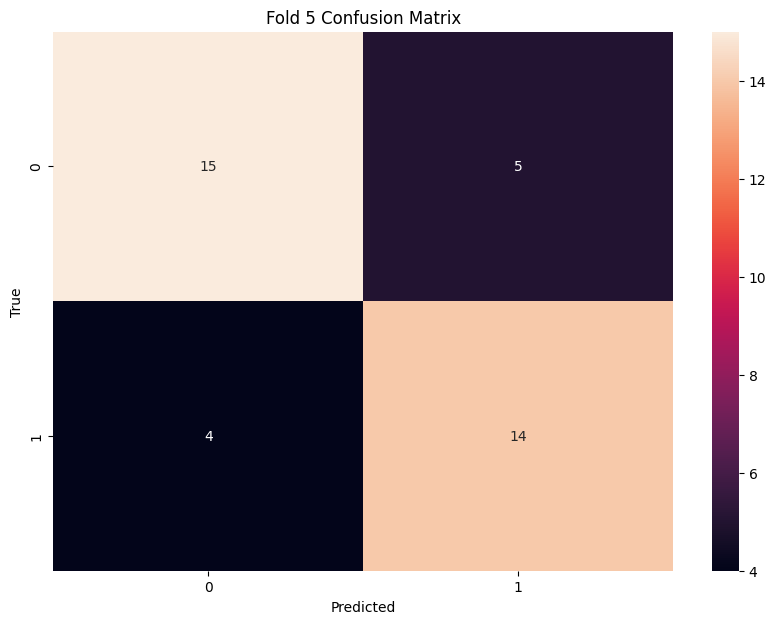

Average Test Accuracy: 0.8499288762446658
Average Test F1 Score: 0.848714211545972


In [33]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize lists to store the accuracy and F1 score for each fold
accuracy_scores = []
f1_scores = []

# Perform cross-validation
for i, (train_index, test_index) in enumerate(cv.split(np.zeros(len(y)), y), start=1):
    # # Split the data into training and test sets
    data.train_mask = index_to_mask(torch.tensor(train_index), size=num_nodes)
    data.test_mask = index_to_mask(torch.tensor(test_index), size=num_nodes)

    # Load the best model
    model.load_state_dict(torch.load(path))

    # predictions with the best model
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]

    # Create a mask for the fake and real news
    news_mask = ((data.y == 0) | (data.y == 1)) & data.test_mask

    # Apply the mask to the labels and predictions
    labels_news = data.y[news_mask]
    preds_news = preds[news_mask]

    # Compute the accuracy and F1 score
    accuracy = accuracy_score(labels_news.cpu(), preds_news.cpu())
    f1 = f1_score(labels_news.cpu(), preds_news.cpu(), average='weighted')

    # Store the accuracy and F1 score
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f'Fold {i} Test Accuracy: {accuracy}')
    print(f'Fold {i} Test F1 Score: {f1}')

    report = classification_report(labels_news.cpu(), preds_news.cpu())
    print(f'Fold {i} Classification Report:')
    print(report)

    cm = confusion_matrix(labels_news.cpu(), preds_news.cpu())

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {i} Confusion Matrix')
    plt.show()

# Compute the average accuracy and F1 score
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Test Accuracy: {average_accuracy}')
print(f'Average Test F1 Score: {average_f1}')